In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./../")

In [3]:
from pathlib import Path
import math
import pickle
#
import torch
import torchvision
from torchvision import utils
import torchvision.transforms as T
#
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#
from misc.plot_utils import plot_mat, imshow
from effcn.models_smallnorb import SmallNorbEffCapsNet
from effcn.functions import create_margin_loss
from effcn.utils import count_parameters
from datasets.smallnorb import SmallNORB
from effcn.functions import masking

### Preprocessing

In [34]:
device = torch.device("cuda")
device

device(type='cuda')

In [5]:
p_experiment = "/mnt/data/experiments/EfficientCN/smallnorb/effcn_smallnorb_2021_12_19_03_12_57"
p_experiment = Path(p_experiment)
p_config = p_experiment / "config.pkl"
p_stats = p_experiment / "stats.pkl"
p_ckpts = p_experiment / "ckpts"
with open(p_config, "rb") as file:
    config = pickle.load(file)
with open(p_stats, "rb") as file:
    stats = pickle.load(file)
#
p_data = config.paths.data
p_model = p_ckpts / config.names.model_file.format(200)
p_model.exists()

True

In [6]:
config.paths.data = '/mnt/data/datasets/smallnorb'
config.paths.data

config.names.model_file.format(200)

'model_200.ckpt'

In [7]:
model = SmallNorbEffCapsNet()
model.load_state_dict(torch.load(p_model))
model = model.to(device)
model.eval()

SmallNorbEffCapsNet(
  (backbone): SmallNorbEcnBackbone(
    (layers): Sequential(
      (0): Conv2d(2, 32, kernel_size=(7, 7), stride=(2, 2), padding=valid)
      (1): LeakyReLU(negative_slope=0.3, inplace=True)
      (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (4): LeakyReLU(negative_slope=0.3, inplace=True)
      (5): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (7): LeakyReLU(negative_slope=0.3, inplace=True)
      (8): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
      (10): LeakyReLU(negative_slope=0.3, inplace=True)
      (11): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )


In [8]:
#Tranformations
transform_train = T.Compose([
    T.Resize(64),
    T.CenterCrop(48),
    T.Normalize(mean=[191.7811/255,193.0594/255,0],std=[45.2232/255, 44.2558/255,1]),
])
transform_valid = T.Compose([
    T.Resize(64),
    T.CenterCrop(48),        
    T.Normalize(mean=[191.0684/255,192.0952/255,0],std=[45.4354/255, 44.3388/255,1]),        
])

In [9]:
    ds_train = SmallNORB(root=p_data,train=True, download=True, transform=transform_train, mode="pseudo")
    ds_valid = SmallNORB(root=p_data,train=False, download=True, transform=transform_valid, mode="pseudo")
  

In [10]:
idx = 0

print(len(ds_train.data))


x,y,_ = ds_train[idx]

x = torch.unsqueeze(x,dim=0)
y = torch.unsqueeze(y,dim=0)

print(x.size())
print(y.size(), y)

24300
torch.Size([1, 2, 48, 48])
torch.Size([1]) tensor([0])


### Generate Capsuls for influenced Reconstruction

In [11]:
x = x.to(device)
y = y.to(device)

uh, _ = model.forward(x, y)

In [12]:
print(uh.size())

torch.Size([1, 5, 16])


In [13]:
m_uh = masking(uh)
x_rec = model.decoder(m_uh)

In [14]:
def imshow(img, cmap="gray", vmin=None, vmax=None):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=cmap, vmin=None, vmax=None)
    plt.show()

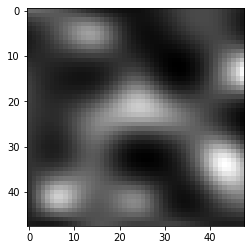

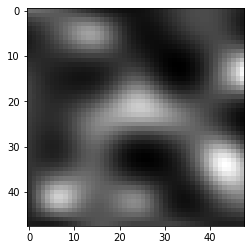

In [15]:
imshow(torch.squeeze(x_rec[:,1:2,:,:],dim=0))
imshow(torch.squeeze(x_rec[:,0:1,:,:],dim=0))

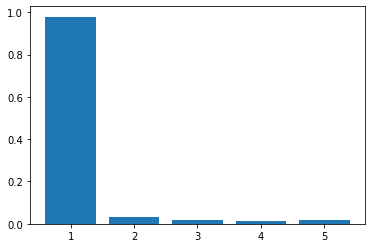

tensor([-0.2609,  0.1872,  0.2466,  0.2395, -0.2275,  0.2753,  0.2738, -0.1998,
         0.2714,  0.2098, -0.1809, -0.1274,  0.3131, -0.2779, -0.3019,  0.2477],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([-0.2609,  0.1872,  0.2466,  0.2395, -0.2275,  0.2753,  0.2738, -0.1998,
         0.2714,  0.2098, -0.1809,  0.8726,  0.3131, -0.2779, -0.3019,  0.2477],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([-0.2227,  0.2287,  0.2349,  0.2855, -0.2384,  0.2854,  0.2494, -0.1704,
         0.3154,  0.1732, -0.1374, -0.1180,  0.3501, -0.2712, -0.2778,  0.2406],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


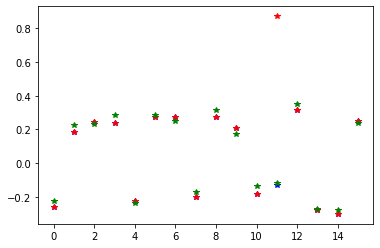

torch.Size([3, 5, 16])

In [16]:
torch.argmax(uh,dim=2)

sq_uh = torch.squeeze(uh,dim=0)
a = torch.norm(sq_uh, dim=1)
plt.bar(np.arange(1,6,1), a.detach().cpu().numpy())
plt.show()

i_cap = torch.argmax(torch.norm(uh, dim=2))
ref = uh[:,i_cap,:]

uh_delta = uh.clone()
uh_delta[:,i_cap,:] += torch.tensor([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]).to(device)
delta = uh_delta[:,i_cap,:]

torch.manual_seed(42)
uh_delta2 = uh.clone()
uh_delta2[:,i_cap,:] += (torch.rand(16).to(device)-0.5) * 0.1
delta2 = uh_delta2[:,i_cap,:]

print(torch.squeeze(ref,dim=0))
plt.plot(torch.squeeze(ref,dim=0).detach().cpu().numpy(),"b*")
print(torch.squeeze(delta,dim=0))
plt.plot(torch.squeeze(delta,dim=0).detach().cpu().numpy(),"r*")
print(torch.squeeze(delta2,dim=0))
plt.plot(torch.squeeze(delta2,dim=0).detach().cpu().numpy(),"g*")
plt.show()



uh_n = torch.cat((uh, uh_delta, uh_delta2), dim=0)  

uh_n.size()

#print(uh_delta-uh)

In [17]:
m_uh_n = masking(uh_n)
x_rec_n = model.decoder(m_uh_n)

torch.Size([3, 2, 48, 48])


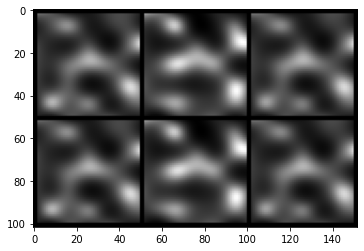

In [18]:
print(x_rec_n.size())
rec = x_rec_n.cpu()
scal = lambda x: (x-x.min())/(x.max()-x.min())
img = torchvision.utils.make_grid(torch.cat([scal(rec[:,0:1,:,:]),scal(rec[:,1:2,:,:])], dim=0), nrow=rec.shape[0])
plt.imshow(img.permute(1,2,0))
plt.show()

### Prepare affine transformations embedding

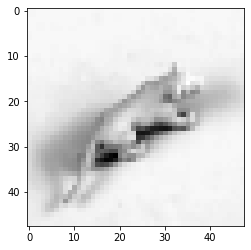

In [19]:
x_aff = T.functional.affine(img=x, angle=0, translate=[0,0], scale=1.,shear=0)

#imshow(torch.squeeze(x[:,1:2,:,:],dim=0))
imshow(torch.squeeze(x_aff[:,1:2,:,:],dim=0))

In [20]:
def affine_xtrans(img, target, range=[-5.,5.,1]):
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    x_trans = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        x_trans[i] = T.functional.affine(img=x, angle=0, translate=[l,0], scale=1.,shear=0)
        l_target[i] = target
    
    return x_trans, l_target

def affine_ytrans(img, target, range=[-5.,5.,1]):
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    y_trans = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        y_trans[i] = T.functional.affine(img=x, angle=0, translate=[0,l], scale=1.,shear=0)
        l_target[i] = target
    
    return y_trans, l_target

def affine_rot(img, target, range=[-25.,25.,1]):
    arange = np.arange(range[0],(range[1]+range[2]),range[2])
    rot = torch.zeros([len(arange),img.shape[1],img.shape[2],img.shape[3]])
    l_target = torch.zeros(len(arange))

    for i, l in enumerate(arange):
        rot[i] = T.functional.affine(img=x, angle=l, translate=[0,0], scale=1.,shear=0)
        l_target[i] = target
    
    return rot, l_target

torch.Size([11, 2, 48, 48])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


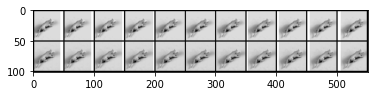

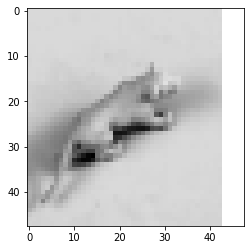

In [21]:
x_trams, y_trans = affine_xtrans(x,y)
print(x_trams.shape)
print(y_trans)

x_trams = x_trams.cpu()
scal = lambda x: (x-x.min())/(x.max()-x.min())
img = torchvision.utils.make_grid(torch.cat([scal(x_trams[:,0:1,:,:]),scal(x_trams[:,1:2,:,:])], dim=0), nrow=x_trams.shape[0])
plt.imshow(img.permute(1,2,0))
plt.show()

imshow(x_trams[0,1:2,:,:])


In [22]:
x_trans, _ = affine_xtrans(x,y)
y_trans, _ = affine_ytrans(x,y)
rot, _ = affine_rot(x,y)

#### ATE on x_trans

In [35]:
#x_aff = x_trans.to(device)
#x_aff = y_trans.to(device)
x_aff = rot.to(device)

uh_aff, _ = model.forward(x_aff)

In [36]:
def cov_uh_trans(uh):
    """
    uh in [k,n,m]
    k -> number of transformed images
    n -> number of output classes
    m -> number of capsul values
    """

    uh_mean = uh.mean(dim=0)
    """
    #could be cleaner, but it's the same ...
    uh_mean = uh_mean.unsqueeze(0)
    uh_mean = uh_mean.repeat(uh.shape[0],1,1)
    """

    z = uh - uh_mean

    c_k = torch.einsum('...ij, ...ik -> ...jk', z,z)
    c = torch.einsum('ijk -> jk', c_k) / c_k.shape[0]

    return c

In [37]:
c = cov_uh_trans(uh_aff)


In [44]:
def covshow(c):
    # https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py

    data = c.cpu().detach().numpy()

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(data)

    fg_color = 'white'
    im.axes.tick_params(color=fg_color, labelcolor=fg_color)

    """
    # Loop over data dimensions and create text annotations.
    for i in range(len(data)):
        for j in range(len(data)):
            text = ax.text(j, i, data[i, j],
                        ha="center", va="center", color="fg_color")
    """

    cb = fig.colorbar(im)
    cb.ax.yaxis.set_tick_params(color=fg_color)
    cb.outline.set_edgecolor(fg_color)
    plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color)
    fig.tight_layout()
    plt.show()

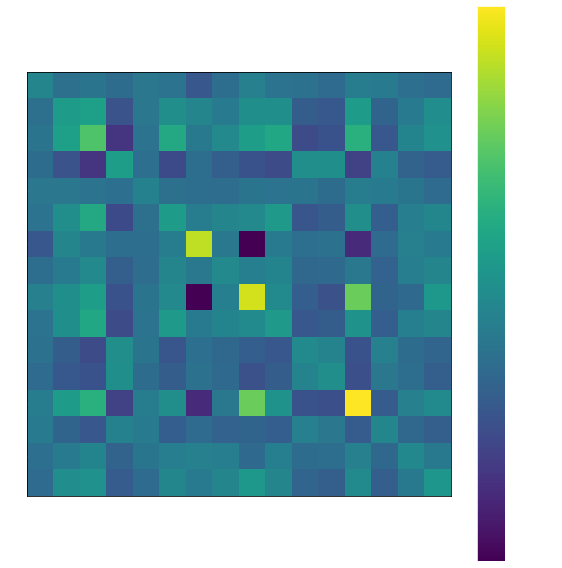

In [45]:
covshow(c)

### via PCA from Paper EffCN

tensor([4.8640e-01, 2.6400e-01, 7.4373e-02, 5.6202e-02, 4.5693e-02, 2.5474e-02,
        2.0043e-02, 1.1016e-02, 7.0574e-03, 4.1433e-03, 2.3823e-03, 1.3559e-03,
        8.7022e-04, 5.6311e-04, 1.6027e-04, 2.6649e-04],
       grad_fn=<DivBackward0>)


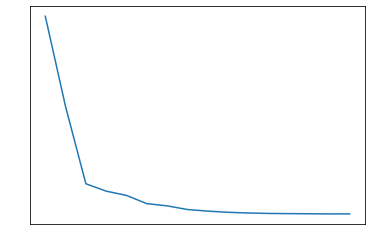

In [39]:
cov = c.cpu()

eig, v_eig = torch.linalg.eig(cov)
eig = eig.float()
sig = eig / eig.sum()

#rint(eig)
#print(eig.sum())
print(sig)
plt.plot(sig.detach().numpy())
plt.tick_params(colors="w")



### Via KL-Divergende from munich paper

In [40]:
### !!! Not shure about this!!!

# https://mail.python.org/pipermail/scipy-user/2011-May/029521.html

def KLdivergence(x, y):
  """Compute the Kullback-Leibler divergence between two multivariate samples.
  Parameters
  ----------
  x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
  y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
  Returns
  -------
  out : float
    The estimated Kullback-Leibler divergence D(P||Q).
  References
  ----------
  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
continuous distributions IEEE International Symposium on Information
Theory, 2008.
  """
  from scipy.spatial import cKDTree as KDTree

  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

In [41]:
def cov_uh_kl(uh):
    c_k = torch.einsum('...ij, ...ik -> ...jk', uh,uh)
    c = torch.einsum('ijk -> jk', c_k) / c_k.shape[0]
    return c 

-16.302411119333012


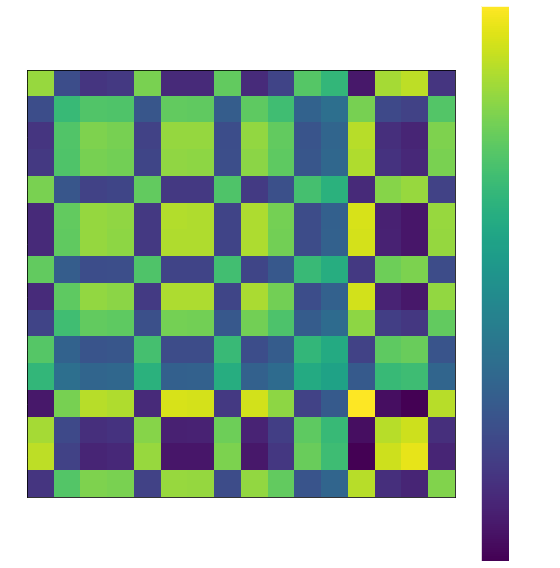

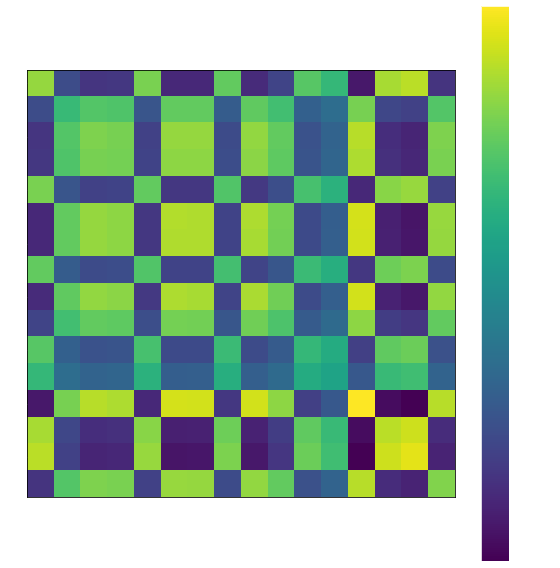

In [47]:
c_org = cov_uh_kl(uh.cpu())
c_aff = cov_uh_kl(uh_aff.cpu())

#determinaten
c_org_det = torch.linalg.det(c_org)
c_aff_det = torch.linalg.det(c_aff)

#trace
c_org_det = torch.trace(c_org)
c_aff_det = torch.trace(c_aff)

#compute kl div from git hub
kl_div = KLdivergence(c_org.detach().numpy(), c_aff.detach().numpy())

print(kl_div)
covshow(c_org)
covshow(c_aff)